# Introduction 
The world is a huge fan of soccer. Players are being sold for millions and somtimes even billions! Of course, Today, the need for data analytics in the sports field is huge. Multiple examples show us that you can use data to plan who to buy, when to buy, and where to place on the field. 

In this project, we would like to explore the data provided by Kaggle on Fifa 20 and the players it involoves. We will soon try to predict the best position for a given player given their data. 

## Datasets / Imports / Environment we are going to use.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We will use numpy for calculations and algebra since it is much faster than the native python math module.
import numpy as np
#pandas will be used in processing, reading, and manipulating/querying the datafile.
import pandas as pd 
#Seaborn is a library based on top of Matplotlib, we will use it for the statistical part of the analysis
import seaborn as sb
#Matplotlib will be used for plotting figure both while discovering the data and throughout the whole notebook.\
import matplotlib.pyplot as plt
#io is to access data uploaded
import io
# Sklearn imports
from sklearn import tree,preprocessing
#ensembles
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
import sklearn.metrics as metrics
#scores
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,roc_auc_score,auc  
#models
from sklearn.model_selection import StratifiedKFold,train_test_split,cross_val_score,learning_curve,GridSearchCV,validation_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from collections import Counter


# Data Discovery

In [ ]:
players_dataframe = pd.read_csv('drive/MyDrive/Colab Notebooks/players_20.csv')
players_dataframe['count'] = 1  #Assit, this will help us when we are goruping in a couple of cells down. 

In [ ]:
players_dataframe.head(10)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,count
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,...,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2,1
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,...,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,1
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,...,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3,1
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,91,93,77500000,125000,GK,Right,3,3,1,Medium/Medium,Normal,Yes,164700000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,...,19,11,65,11,68,27,12,18,87,92,78,90,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,...,41,87,89,88,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3,1
5,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,28,1991-06-28,181,70,Belgium,Manchester City,91,91,90000000,370000,"CAM, CM",Right,4,5,4,High/High,Normal,Yes,166500000.0,"#Dribbler, #Playmaker , #Engine, #Distance Sh...",RCM,17.0,NaN,2015-08-30,2023.0,RCM,7.0,76.0,86.0,92.0,86.0,61.0,78.0,NaN,NaN,NaN,...,61,88,94,79,91,68,58,51,15,13,5,10,13,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,1
6,192448,https://sofifa.com/player/192448/marc-andre-te...,M. ter Stegen,Marc-André ter Stegen,27,1992-04-30,187,85,Germany,FC Barcelona,90,93,675

### Looks too confusing? Let's narrow it down so we can get a better overall picture.
#### Rows and Columns Numbers

In [ ]:
def getRxC(df):
  row = len(df.index)
  cols = len(list(df))
  return [row, cols] 
print(f"The Dataset has {getRxC(players_dataframe)[0]} rows and {getRxC(players_dataframe)[1]} columns ")

The Dataset has 18278 rows and 105 columns 


But are we considering all the palyers? That's 18 thousand players, maybe there are some players whose values are close to or even zero. Let's check for that.

In [ ]:
players_dataframe = players_dataframe[players_dataframe['value_eur'] > 1]

Now let's get the count again

In [ ]:
print(f"The Dataset has {getRxC(players_dataframe)[0]} rows and {getRxC(players_dataframe)[1]} columns ")

The Dataset has 18028 rows and 105 columns 


Exactly, some rows were removed. Now, Let's have a look at a subsection of the columns to know what we are up to against here.

## Let's do some visualization.
First off, we will start with doing some aggregation on the teams and then we will go down to aggregating the players in terms of position/teams as well.
 


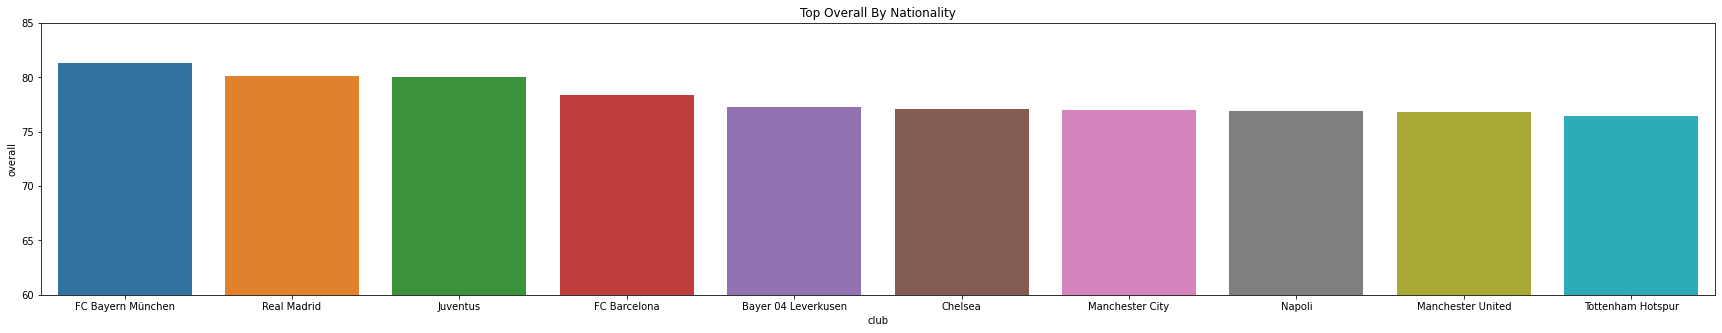

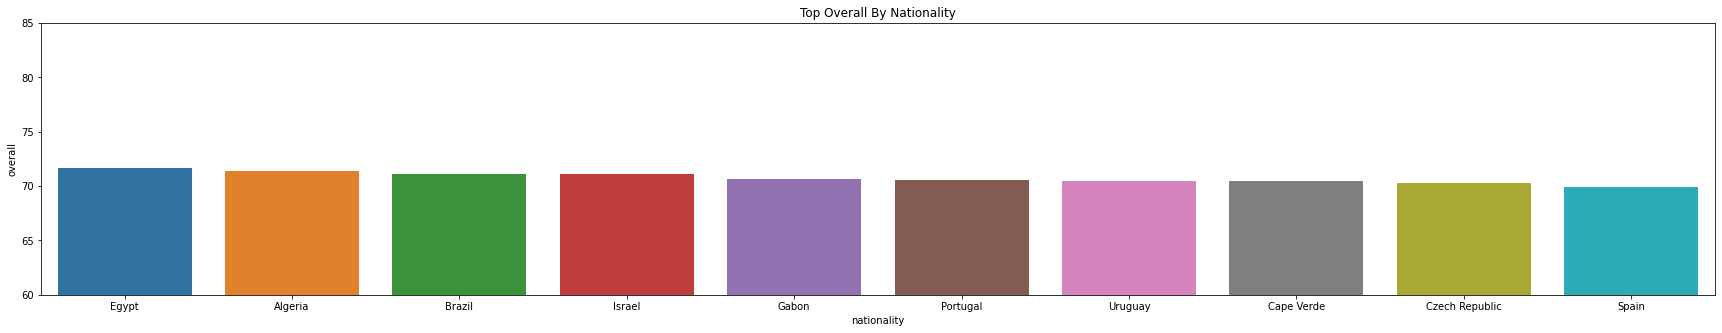

In [ ]:
def top_n_charts(field, n):
    players_dataframe_club = players_dataframe.groupby([field]).mean()
    players_dataframe_club = players_dataframe_club.sort_values('overall', ascending = False).reset_index()

    ls = players_dataframe.groupby([field]).sum()
    ls = ls[ls['count'] > 10].index
    players_dataframe_club = players_dataframe_club[players_dataframe_club[field].isin(ls)]

    f, ax = plt.subplots(figsize = (30,5))
    sb.barplot(x = field, y = 'overall', data = players_dataframe_club.iloc[:n])
    ax.set(ylim = (60,85))

top_n_charts('club', 10)
top_n_charts('nationality', 10)




In [ ]:
# Graphing count per position
pos_column = players_dataframe['player_positions']
# Some players have more than one position, we will split that and count after
result = []
for i in pos_column:
  if len(i.split(",")) > 1:
    for j in i.split(","):
      result.append(j.strip())
  else:
    result.append(i)

counter = Counter(result)
counter #let's check out the count 

Counter({'CAM': 2165,
         'CB': 3680,
         'CDM': 2684,
         'CF': 370,
         'CM': 3788,
         'GK': 1996,
         'LB': 1981,
         'LM': 2378,
         'LW': 973,
         'LWB': 311,
         'RB': 1979,
         'RM': 2290,
         'RW': 967,
         'RWB': 294,
         'ST': 3218})

In [ ]:
# Check summation of positions which is expected to be larger than the number of players because some players have up to 3 positions
sum(counter.values())

29074

Text(0.5, 1.0, 'Position and their count')

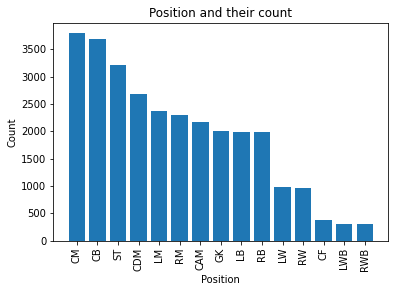

In [ ]:
# Sort by count before plotting
sorted_counter = counter.most_common() #this lists the most comment elements from the most to least
x = []
y = []
for i in range(len(sorted_counter)):
  x.append(sorted_counter[i][0])
  y.append(sorted_counter[i][1])

plt.bar(x, y)
plt.xticks(x, x, rotation='vertical')
plt.xlabel("Position")
plt.ylabel("Count")
plt.title("Position and their count")

Text(0.5, 1.0, 'Prefered Foot by count')

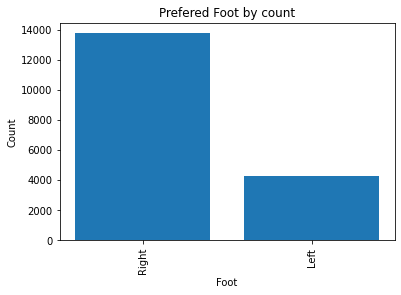

In [ ]:
foot_column = players_dataframe['preferred_foot']
counter2 = Counter(foot_column)

sorted_counter2 = counter2.most_common() #this lists the most comment elements from the most to least
x2 = []
y2 = []
for i in range(len(sorted_counter2)):
  x2.append(sorted_counter2[i][0])
  y2.append(sorted_counter2[i][1])

plt.bar(x2, y2)
plt.xticks(x2, x2, rotation='vertical')
plt.xlabel("Foot")
plt.ylabel("Count")
plt.title("Prefered Foot by count")

Text(0.5, 1.0, 'Top players (Overall >86)')

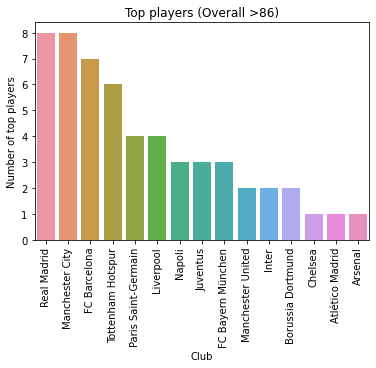

In [ ]:
# Top player distribution accordting to overall per club
thr = 86

best = players_dataframe[players_dataframe['overall']>thr]
grouped = best.groupby('club')
count_by_club = grouped.count()['short_name'].sort_values(ascending = False)

ax = sb.countplot(x = 'club', data = best, order = count_by_club.index)

ax.set_xticklabels(labels = count_by_club.index, rotation='vertical')
ax.set_ylabel('Number of top players')
ax.set_xlabel('Club')
ax.set_title('Top players (Overall >%.i)' %thr)

Text(0.5, 1.0, 'Top players (Value >50000000)')

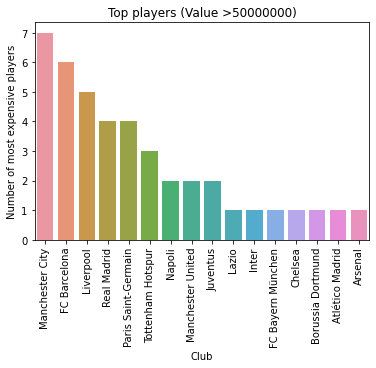

In [ ]:
# Top player distribution according to value/price in euros per club
thr2 = 10**7 * 5 # 50 Million euros

most_expensive = players_dataframe[players_dataframe['value_eur']>thr2]
grouped = most_expensive.groupby('club')
count_by_club2 = grouped.count()['short_name'].sort_values(ascending = False)

ax = sb.countplot(x = 'club', data = most_expensive, order = count_by_club2.index)

ax.set_xticklabels(labels = count_by_club2.index, rotation='vertical')
ax.set_ylabel('Number of most expensive players')
ax.set_xlabel('Club')
ax.set_title('Top players (Value >%.i)' %thr2)


Interesting result, notice the club names are similar in both metrics. Perhaps meaning that there is a correlation between the wage/price of a player and their overall performance, let us scatter plot the two and see

Text(0.5, 0, 'Overall')

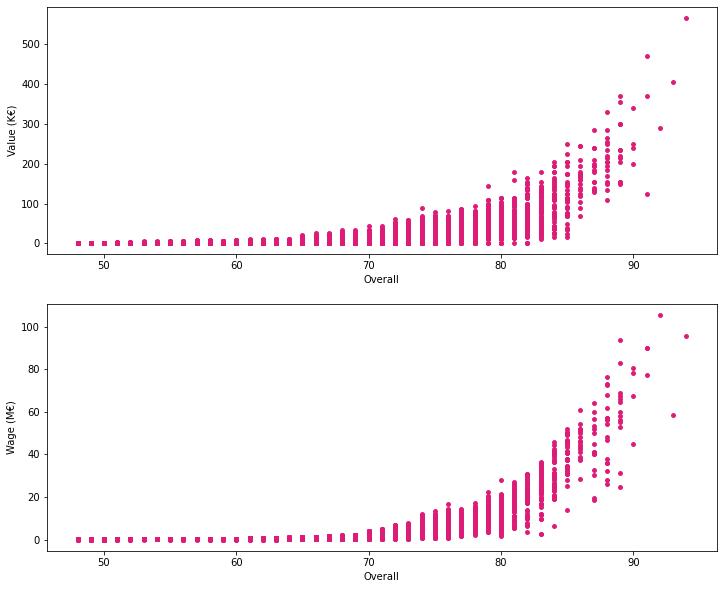

In [ ]:
fig = plt.figure(figsize=(12,10))    

ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0))

ax1.scatter(players_dataframe['overall'], players_dataframe['wage_eur'].apply(lambda x: x/1000), s = 15, color = '#dd1c77')
ax2.scatter(players_dataframe['overall'], players_dataframe['value_eur'].apply(lambda x: x/1000000), s = 15, color = '#dd1c77')
ax2.set_xlabel('Overall')
ax2.set_ylabel('Value (M€)')
ax2.set_ylabel('Wage (M€)')
ax1.set_ylabel('Value (K€)')
ax1.set_xlabel('Overall')

Indeed there seems to be a correlation between the two.

# Data cleaning / preprocessing and feature selection

In [ ]:
#Imputation
def impute_data(df): 
    df.fillna(0, inplace = True) #Fills NA/NaN values with 0.
    
#One Hot Encoding of a feature
def one_hot_encoding(df,column): # this is used for the left/right foot encoder, we will show this in a couple of cells down.
    encoder = preprocessing.LabelEncoder() #this encodes the values of "Y" between 0 and n_classes - 1
    df[column] = encoder.fit_transform(df[column].values)
        

#Drop columns that we are not interested in
def drop_columns(df):
    r1 = [0, 1, 2, 3, 5, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 43]
    r2 = list(np.arange(start=78, stop=104)) #this just returns evenly spaced values within 78, 104
    arr = np.concatenate((r1, r2), axis = 0) #inplace drop of all columns.
    df.drop(df.columns[[arr]], axis = 1, inplace = True)
    

#If player has more than 1 position select 1st for simplicity
def narrow_down_positions(df):
    df['player_positions'] = df['player_positions'].str.split(',').str[0]

#Transform positions to 3 categories 'Striker', 'Midfielder', 'Defender'    
def transform_positions(df):
    for i in ['ST', 'CF', 'LF', 'LS', 'LW', 'RF', 'RS', 'RW']:
      df.loc[df.player_positions == i , 'player_positions'] = 'Striker' 
    
    for i in ['CAM', 'CDM', 'LCM', 'CM', 'LAM', 'LDM', 'LM', 'RAM', 'RCM', 'RDM', 'RM']:
      df.loc[df.player_positions == i , 'player_positions'] = 'Midfielder' 
    
    for i in ['CB', 'LB', 'LCB', 'LWB', 'RB', 'RCB', 'RWB','GK']:
      df.loc[df.player_positions == i , 'player_positions'] = 'Defender' 

In [ ]:
# Copying dataframe
df = players_dataframe.copy() # just in case we wanted to visualize sth else.
# Drop columns that we are not interested in
drop_columns(df)
# Impute the data that is null
impute_data(df)
# apply the one hot encoding to the Preferred foot (L,R) => (0,1)
one_hot_encoding(df,'preferred_foot')
# select first position if multiple are available
narrow_down_positions(df)
# transform position to striker, midfielder, defender
transform_positions(df)
# show the 10 first rows
print(len(df.columns))
df.head(10) #this is going to be our feature df.

52


/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


,age,height_cm,weight_kg,player_positions,preferred_foot,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,count
0,32,170,72,Striker,0,87.0,92.0,92.0,96.0,39.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,1
1,34,187,83,Striker,1,90.0,93.0,82.0,89.0,35.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,1
2,27,175,68,Striker,1,91.0,85.0,87.0,95.0,32.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,1
3,26,188,87,Defender,1,0.0,0.0,0.0,0.0,0.0,0.0,87.0,92.0,78.0,89.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,1
4,28,175,74,Striker,1,91.0,83.0,86.0,94.0,35.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8,1
5,28,181,70,Midfielder,1,76.0,86.0,92.0,86.0,61.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,93,82,55,92,82,86,85,83,91,91,77,76,78,91,76,91,63,89,74,90,76,61,88,94,79,91,68,58,51,15,13,5,10,13,1
6,27,187,85,Defender,1,0.0,0.0,0.0,0.0,0.0,0.0,88.0,85.0,88.0,90.0,45.0,88.0,18,14,11,61,14,21,18,12,63,30,38,50,37,86,43,66,79,35,78,10,43,22,11,70,25,70,25,13,10,88,85,88,88,90,1
7,27,193,92,Defender,1,77.0,60.0,70.0,71.0,90.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,53,52,86,78,45,70,60,70,81,76,74,79,61,88,53,81,90,75,92,64,82,89,47,65,62,89,91,92,85,13,10,13,11,11,1
8,33,172,66,Midfielder,1,74.0,76.0,89.0,89.0,72.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,86,72,55,92,76,87,85,78,88,92,77,71,92,89,93,79,68,85,58,82,62,82,79,91,82,92,68,76,71,13,9,7,14,9,1
9,27,175,71,Striker,0,93.0,86.0,81.0,89.0,45.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,79,90,59,84,79,89,83,69,75,89,94,92,91,92,88,80,69,85,73,84,63,55,92,84,77,91,38,43,41,14,14,9,11,14,1


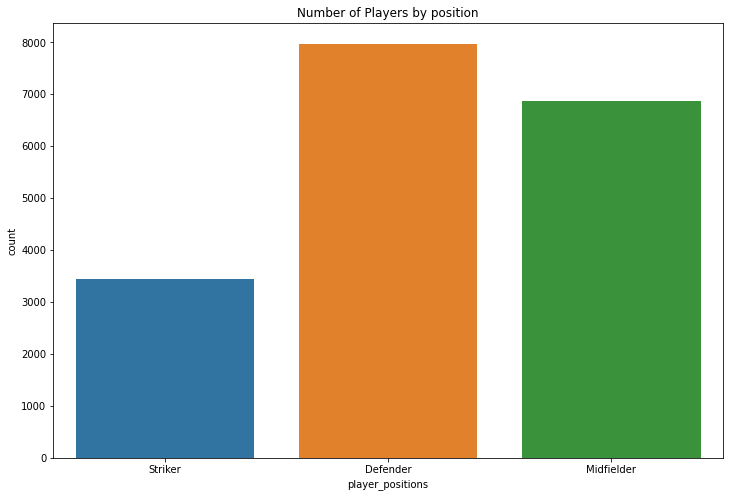

In [ ]:
# Count number of players in each position using countplot
plt.figure(figsize=(12, 8))
plt.title("Number of Players by position")
fig = sb.countplot(x = 'player_positions', data =df)

# Splitting dataset into training set and test set

In [ ]:
# Create the unique values for the positions encoded as Defender:0, Midfielder:1, Striker:2
positions = df["player_positions"].unique()
encoder = preprocessing.LabelEncoder()
df['player_positions'] = encoder.fit_transform(df['player_positions'])

#The Y feature is the position
y = df["player_positions"]

#The other features are all but the position
df.drop(columns=["player_positions"],inplace=True)



#Split the data
X_train_dev, X_test, y_train_dev, y_test = train_test_split(df, y, 
                                                    test_size=0.20, 
                                                    random_state=42 )

# Applying learning algorithms

Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

In [ ]:
# Plot the confusion matrix
def plot_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    sb.set(font_scale=1.4)
    try:
        heatmap = sb.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
def plot_curve(ticks, train_scores, test_scores):
    train_scores_mean = -1 * np.mean(train_scores, axis=1)
    train_scores_std = -1 * np.std(train_scores, axis=1)
    test_scores_mean = -1 * np.mean(test_scores, axis=1)
    test_scores_std = -1 * np.std(test_scores, axis=1)

    plt.figure()
    plt.fill_between(ticks, 
                     train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.1, color="b")
    plt.fill_between(ticks, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, alpha=0.1, color="r")
    plt.plot(ticks, train_scores_mean, 'b-', label='Training Error')
    plt.plot(ticks, test_scores_mean, 'r-', label='Validation Error')
    plt.legend(fancybox=True, facecolor='w')

    return plt.gca()

def plot_validation_curve(clf, X, y, param_name, param_range, scoring='accuracy'):
    plt.xkcd()
    ax = plot_curve(param_range, *validation_curve(clf, X, y, cv=4, 
                                                   scoring=scoring, 
                                                   param_name=param_name, 
                                                   param_range=param_range, n_jobs=4))
    ax.set_title('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(2,12)
    ax.set_ylim(-0.97, -0.83)
    ax.set_ylabel('Error')
    ax.set_xlabel('Model complexity')
    ax.text(9, -0.94, 'Overfitting', fontsize=14)
    ax.text(3, -0.94, 'Underfitting', fontsize=14)
    ax.axvline(7, ls='--')
    plt.tight_layout()

In [ ]:
def train_and_score(clf,X_train,y_train,X_test,y_test):
    clf = clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    cf = confusion_matrix(y_test,preds)

    print(plot_confusion_matrix(cf, class_names=positions))

    print(" Accuracy: ",accuracy_score(y_test, preds))
    print(" F1 score: ",metrics.f1_score(y_test, preds,average='weighted'))

**Side note**: some algorithms took long to converge and the results are under all the convergence warnings, we tried increasing max_iter but for some models that hurt the accuracy.

# Logistic Regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Figure(720x504)
 Accuracy:  0.8944201312910285
 F1 score:  0.8939993093939301


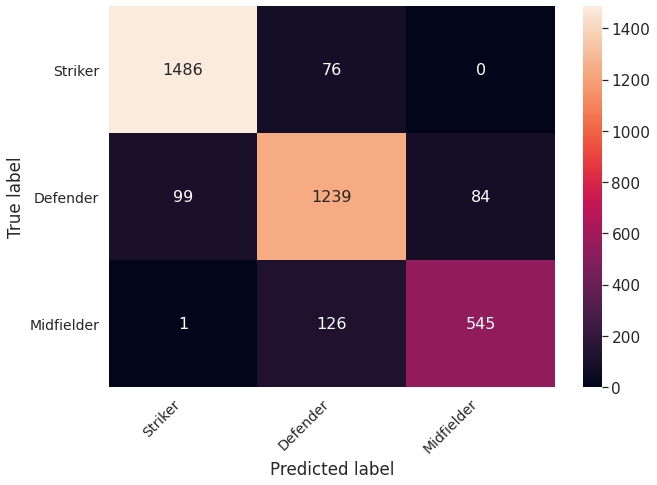

In [ ]:
LR = LogisticRegressionCV(cv=5,random_state=20, solver='lbfgs',
                             multi_class='multinomial')
train_and_score(LR,X_train_dev,y_train_dev,X_test,y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

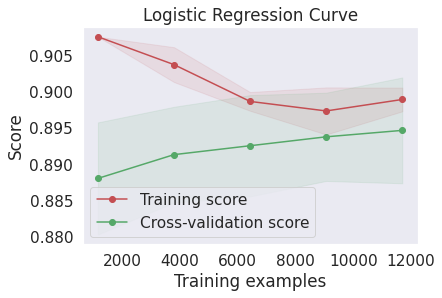

In [ ]:
plot_learning_curve(LR, "Logistic Regression Curve", X_train_dev, y_train_dev) 

# Decision Trees

In [ ]:
# Calculates the best minimum impurity parameter to pass to the decision tree.
def min_impurity(X,y):
    tr_acc = []
    mln_set = range(75,90)                                 

    for minImp in mln_set:
        clf = tree.DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=minImp/100000)
        scores = cross_val_score(clf, X, y, cv=10)
        tr_acc.append(scores.mean())

    best_mln = mln_set[np.argmax(tr_acc)]
    return best_mln

best_min= min_impurity(X_train_dev,y_train_dev)

Figure(720x504)
 Accuracy:  0.8651531728665208
 F1 score:  0.8641860309287072


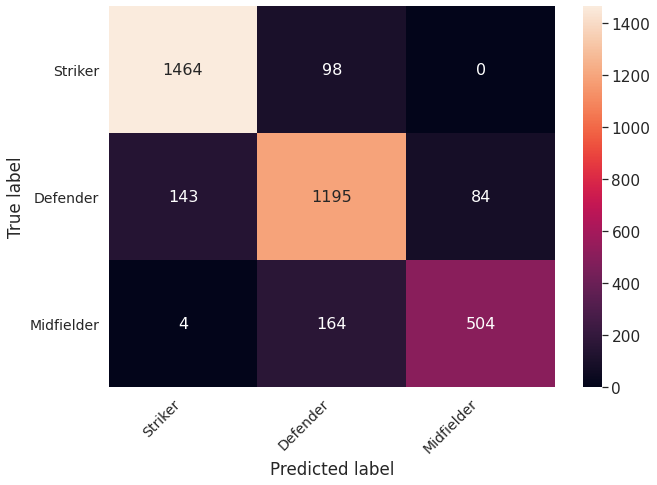

In [ ]:
DT = tree.DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=best_min/100000)
train_and_score(DT,X_train_dev,y_train_dev,X_test,y_test)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

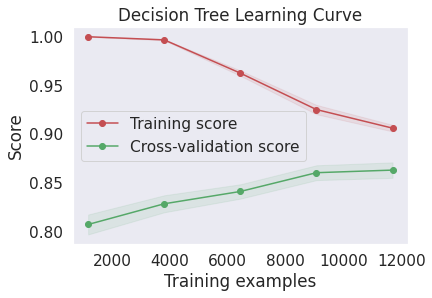

In [ ]:
plot_learning_curve(DT, "Decision Tree Learning Curve", X_train_dev, y_train_dev)

# Neural Networks

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Figure(720x504)
 Accuracy:  0.8826586433260394
 F1 score:  0.8824553898901761


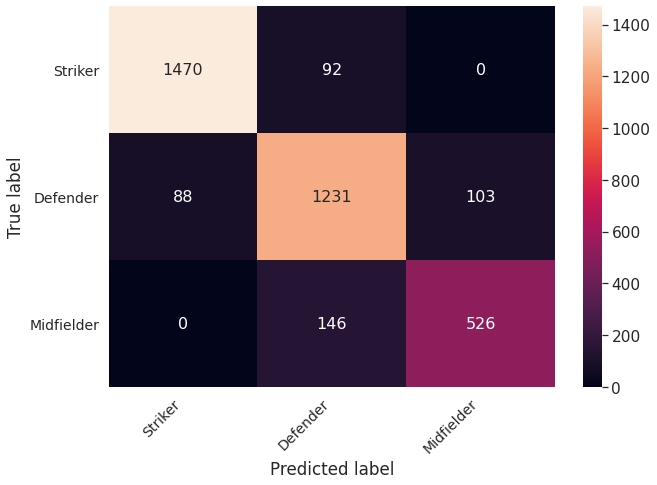

In [ ]:
MLP = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
train_and_score(MLP,X_train_dev,y_train_dev,X_test,y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Figure(720x504)
 Accuracy:  0.8911378555798687
 F1 score:  0.8907410932279508


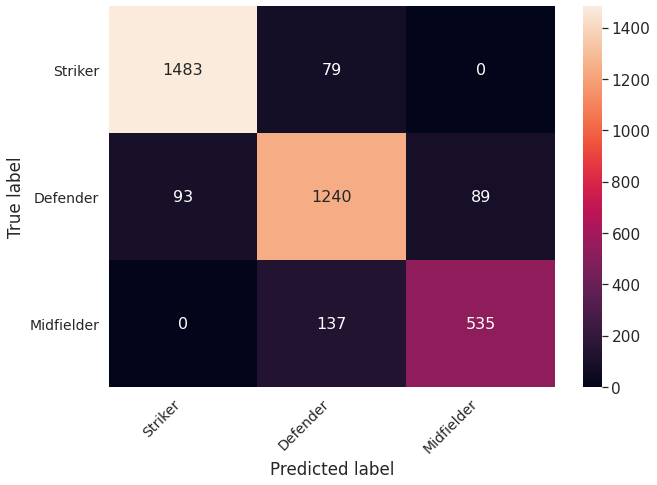

In [ ]:
MLP = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(10, 5), random_state=1)
train_and_score(MLP,X_train_dev,y_train_dev,X_test,y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Figure(720x504)
 Accuracy:  0.8946936542669585
 F1 score:  0.8941218831085793


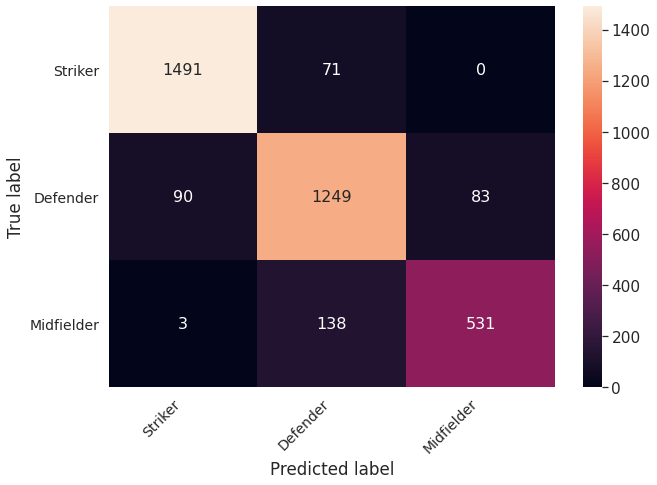

In [ ]:
MLP = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(20, 15), random_state=1)
train_and_score(MLP,X_train_dev,y_train_dev,X_test,y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

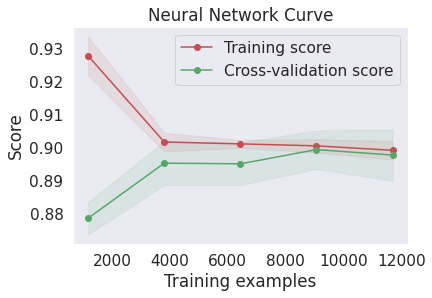

In [ ]:
plot_learning_curve(MLP, "Neural Network Curve", X_train_dev, y_train_dev)

# SVM

Figure(720x504)
 Accuracy:  0.8925054704595186
 F1 score:  0.8919126985937179


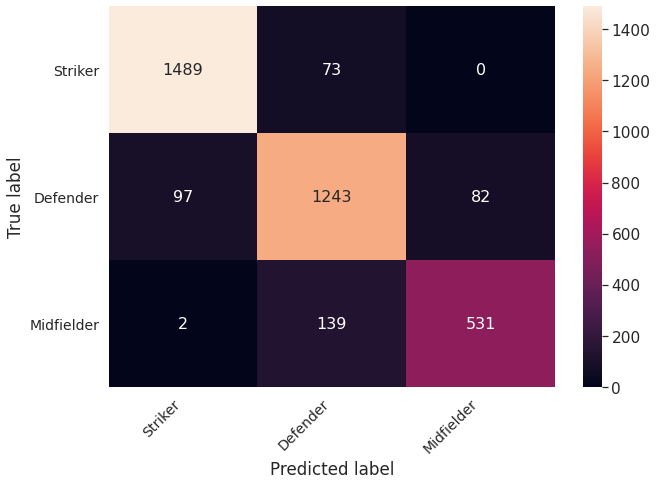

In [ ]:
SVM = SVC(kernel='linear', C=1)
train_and_score(SVM,X_train_dev,y_train_dev,X_test,y_test) 

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

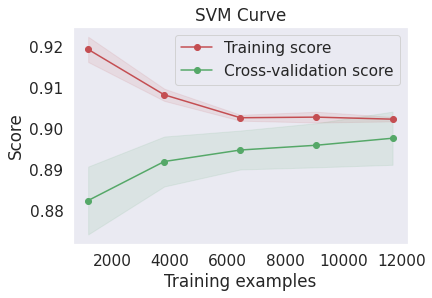

In [ ]:
plot_learning_curve(SVM, "SVM Curve", X_train_dev, y_train_dev)

# 15 Class classification attempt

In [ ]:
#mapping_all = {'ST': 0, 'RW': 1, 'LW': 2, 'RM': 3, 'CM': 4, 'LM': 5, 'CAM': 6, 'CF': 7, 'CDM': 8, 'CB': 9, 'LB': 10, 'RB': 11, 'RWB': 12, 'LWB': 13}
#df2 = players_dataframe.copy() # used later for 16 classes
#drop_columns(df2)
#narrow_down_positions(df2)




#df2 = df2.replace({'player_positions': mapping_all})
#print(df2['player_positions'][0:50])

# Copying dataframe
df2 = players_dataframe.copy()
# Drop columns that we are not interested in
drop_columns(df2)
# Impute the data that is null
impute_data(df2)
# apply the one hot encoding to the Preferred foot (L,R) => (0,1)
one_hot_encoding(df2,'preferred_foot')
# select first position if multiple are available
narrow_down_positions(df2)

# Encoding positions into numbers

positions = df2["player_positions"].unique()
encoder = preprocessing.LabelEncoder()
df2['player_positions'] = encoder.fit_transform(df2['player_positions'])

# show the 10 first rows
df2.head(10)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


,age,height_cm,weight_kg,player_positions,preferred_foot,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,count
0,32,170,72,12,0,87.0,92.0,92.0,96.0,39.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,1
1,34,187,83,14,1,90.0,93.0,82.0,89.0,35.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,1
2,27,175,68,8,1,91.0,85.0,87.0,95.0,32.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,1
3,26,188,87,5,1,0.0,0.0,0.0,0.0,0.0,0.0,87.0,92.0,78.0,89.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,1
4,28,175,74,8,1,91.0,83.0,86.0,94.0,35.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8,1
5,28,181,70,0,1,76.0,86.0,92.0,86.0,61.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,93,82,55,92,82,86,85,83,91,91,77,76,78,91,76,91,63,89,74,90,76,61,88,94,79,91,68,58,51,15,13,5,10,13,1
6,27,187,85,5,1,0.0,0.0,0.0,0.0,0.0,0.0,88.0,85.0,88.0,90.0,45.0,88.0,18,14,11,61,14,21,18,12,63,30,38,50,37,86,43,66,79,35,78,10,43,22,11,70,25,70,25,13,10,88,85,88,88,90,1
7,27,193,92,1,1,77.0,60.0,70.0,71.0,90.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,53,52,86,78,45,70,60,70,81,76,74,79,61,88,53,81,90,75,92,64,82,89,47,65,62,89,91,92,85,13,10,13,11,11,1
8,33,172,66,4,1,74.0,76.0,89.0,89.0,72.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,86,72,55,92,76,87,85,78,88,92,77,71,92,89,93,79,68,85,58,82,62,82,79,91,82,92,68,76,71,13,9,7,14,9,1
9,27,175,71,12,0,93.0,86.0,81.0,89.0,45.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,79,90,59,84,79,89,83,69,75,89,94,92,91,92,88,80,69,85,73,84,63,55,92,84,77,91,38,43,41,14,14,9,11,14,1


# Splitting into test data and training data

In [ ]:
#The Y feature is the position
y = df2["player_positions"]

#The other features are all but the position
df2.drop(columns=["player_positions"],inplace=True)

#Split the data
X_train_dev, X_test, y_train_dev, y_test = train_test_split(df2, y, 
                                                    test_size=0.20, 
                                                    random_state=42 )


# 15 Class Logistic Regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Figure(720x504)
 Accuracy:  0.7344091903719913
 F1 score:  0.719436534520743


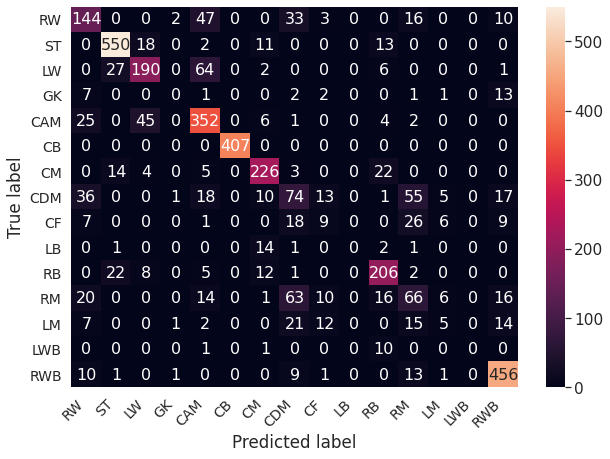

In [ ]:
LR = LogisticRegressionCV(cv=5,random_state=20, solver='lbfgs',
                             multi_class='multinomial')
train_and_score(LR,X_train_dev,y_train_dev,X_test,y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown 

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

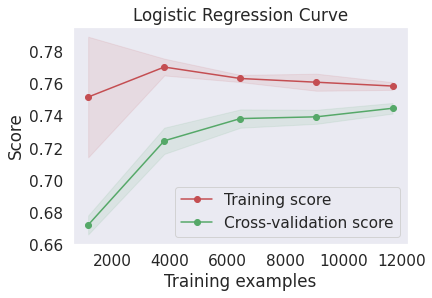

In [ ]:
plot_learning_curve(LR, "Logistic Regression Curve", X_train_dev, y_train_dev) # takes very very very long time to run

# 15 Class Decision Trees

Figure(720x504)
 Accuracy:  0.6534463894967177
 F1 score:  0.6390853542739017


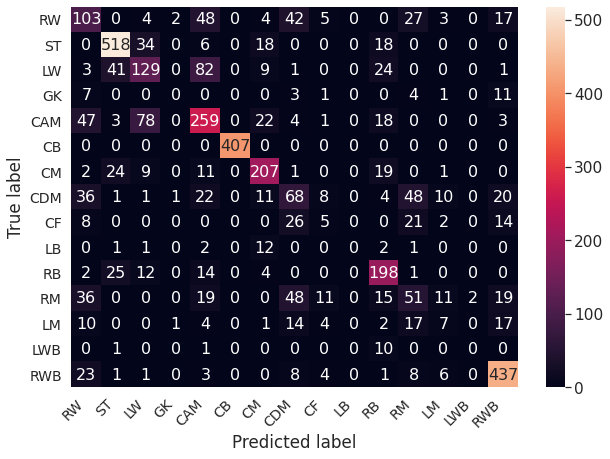

In [ ]:
DT = tree.DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=best_min/100000)
train_and_score(DT,X_train_dev,y_train_dev,X_test,y_test)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

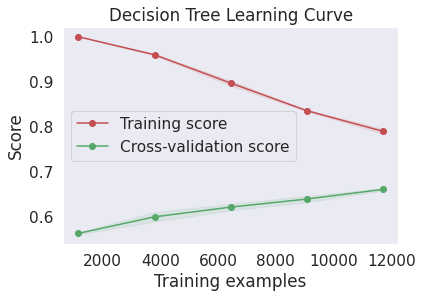

In [ ]:
plot_learning_curve(DT, "Decision Tree Learning Curve", X_train_dev, y_train_dev)

# 15 Class Neural Networks

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Figure(720x504)
 Accuracy:  0.5719365426695843
 F1 score:  0.5124141738237474


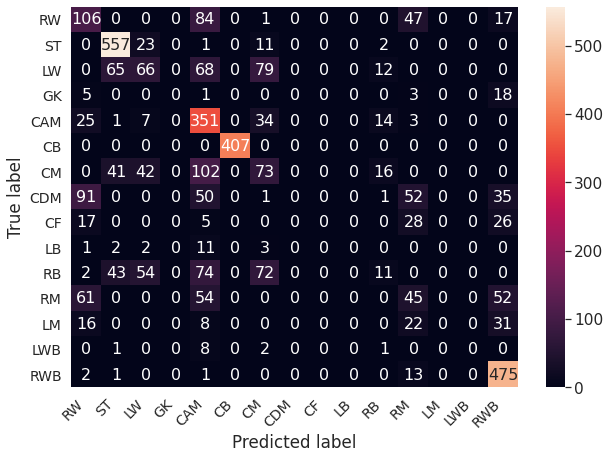

In [ ]:
MLP = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(20, 15), random_state=1, max_iter=1000)
train_and_score(MLP,X_train_dev,y_train_dev,X_test,y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

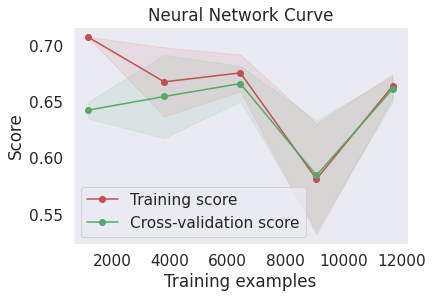

In [ ]:
plot_learning_curve(MLP, "Neural Network Curve", X_train_dev, y_train_dev)

# 15 Class SVM

Figure(720x504)
 Accuracy:  0.7469912472647703
 F1 score:  0.7267361262469062


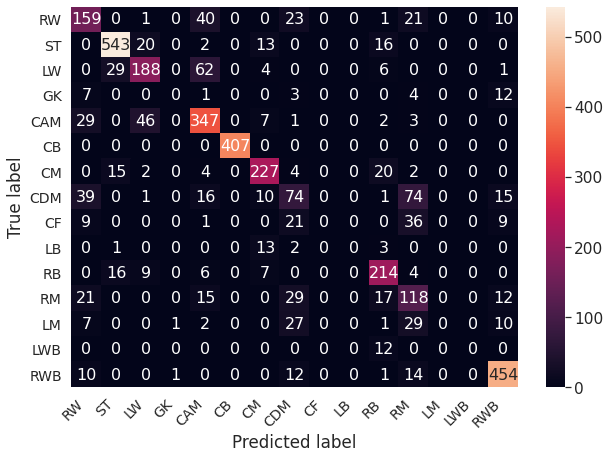

In [ ]:
SVM = SVC(kernel='linear', C=1)
train_and_score(SVM,X_train_dev,y_train_dev,X_test,y_test) # takes long to run

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

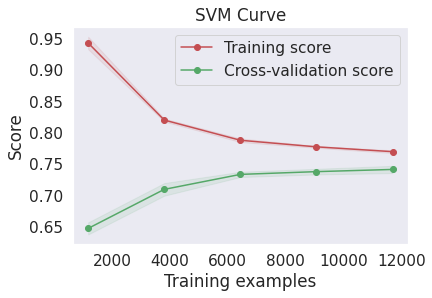

In [ ]:
plot_learning_curve(SVM, "SVM Curve", X_train_dev, y_train_dev) # infinite r